# Confusion Matrices

---

In the [last post](https://scottminer.netlify.app/post/cross-validation/), we used stratified *k*-fold cross-validation to evaluate the accuracy of the `SGDClassifier` we built that classifies images from the MNIST dataset as either fives or non-fives. However, as we will learn in this post, confusion matrices are often better at evaluating classifiers, especially when dealing with unbalanced datasets because, as we learned in the last post, the accuracy metric can be misleading. If only 10% of the images are not 5, a classifier that always predicts not a five will produce an accuracy score of 90%. However, it never correctly classifies any target class instances or, in this case, the number five.

To compute confusion matrices, we need to obtain a set of predictions on the training data set. The test or evaluation dataset should only be used for a final evaluation. To get these predictions, we can use the `cross_val_predict()` method of `sklearn.`


## Baseline Classifier

---


In [1]:
from imports.mlwpy import *
%matplotlib inline

### Load Iris Dataset

---

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

iris = datasets.load_iris()

tts = train_test_split(iris.data, iris.target, test_size=.33, random_state=21)

(iris_train_ftrs, iris_test_ftrs,
iris_train_tgt, iris_test_tgt) = tts

In [3]:
iris_train_ftrs[:10]

array([[6.9, 3.1, 4.9, 1.5],
       [5. , 3.3, 1.4, 0.2],
       [6.7, 3.1, 4.4, 1.4],
       [7.7, 2.6, 6.9, 2.3],
       [5.7, 2.8, 4.5, 1.3],
       [5.8, 2.7, 4.1, 1. ],
       [4.6, 3.1, 1.5, 0.2],
       [5.1, 3.5, 1.4, 0.3],
       [7.7, 3. , 6.1, 2.3],
       [4.7, 3.2, 1.6, 0.2]])

In [4]:
iris_train_tgt[:10]

array([1, 0, 1, 2, 1, 1, 0, 0, 2, 0])

In [5]:
iris_test_ftrs[:10]

array([[5.8, 2.6, 4. , 1.2],
       [5.1, 3.8, 1.9, 0.4],
       [5. , 3.4, 1.5, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [5.7, 3. , 4.2, 1.2],
       [6.6, 3. , 4.4, 1.4],
       [5.4, 3.4, 1.7, 0.2],
       [5.6, 2.8, 4.9, 2. ],
       [5. , 3.4, 1.6, 0.4],
       [5.1, 3.8, 1.5, 0.3]])

In [6]:
iris_test_tgt[:10]

array([1, 0, 0, 0, 1, 1, 0, 2, 0, 0])

In `sklearn,` baseline methods are known as dummy methods and represent the most basic estimators we can conceive. Let's imagine four levels of learning systems. 

1. Baseline methods - predictions based on simple statistics or random guesses
2. Simple off-the-shelf learning methods -predictors that are generally less resource-intensive
3. Complex off-the-shelf learning methods - predictors that are generally more resource-intensive
4. Customized, boutique learning methods


`sklearn` provides four baseline classification methods. Each method makes a prediction when given a test example. There are two **random** baseline methods and two that return **constant** values. The random methods flip coins to make predictions for examples, whereas the constant methods always predict the same thing.

The random methods are (1) `uniform,` which chooses evenly among the target classes based on the *number* of classes, and (2) `stratified,` which chooses evenly among the target classes based on the *frequency* of the classes. The two constant methods are (1) `constant,` which returns one target class we've picked out, and (2) `most_frequent,` which returns the single most likely class. `most_frequent` is also available under the name `prior.`

The two random methods behave differently when a dataset has rare occurrences, such as a rare disease. The `uniform` method picks evenly, 50%-50%, between sick and healthy people. The `stratified` method determines whether healthy or unhealthy as the target based on the data's percentages of healthy and ill people. Let's look at a simple example of a dummy classifier.

In [7]:
import numpy as np
from sklearn.dummy import DummyClassifier

X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

DummyClassifier(strategy='most_frequent')

In [8]:
dummy_clf.predict(X)

array([1, 1, 1, 1])

In [9]:
dummy_clf.score(X, y)

0.75

Let's expand this example to the Iris dataset.

[[ 0 32]
 [ 1 33]
 [ 2 35]]


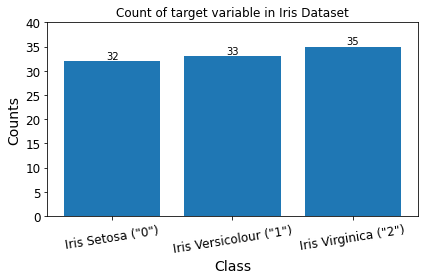

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
values, counts = np.unique(iris_train_tgt, return_counts=True)
print(np.c_[values, counts])
bars = plt.bar(values, counts)
plt.title("Count of target variable in Iris Dataset")
plt.xlabel("Class")
plt.ylabel("Counts")
labels = ['Iris Setosa ("0")', 'Iris Versicolour ("1")', 'Iris Virginica ("2")']
plt.xticks(values, labels, rotation=9)
plt.bar_label(bars, label_type="edge")
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create the baseline classifier using the most_frequent strategy
baseline = DummyClassifier(strategy="most_frequent")
baseline

DummyClassifier(strategy='most_frequent')

In [12]:
baseline.fit(iris_train_ftrs, iris_train_tgt)
base_preds = baseline.predict(iris_test_ftrs)
print(len(base_preds))
print(base_preds)

50
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [13]:
base_acc = accuracy_score(base_preds, iris_test_tgt)
print(base_acc)

0.3


Let's compare the performance of the simple baseline strategies against each other:

In [14]:
strategies = ['constant', 'uniform', 'stratified', 'prior', 'most_frequent']

# set up args to create different DummyClassifier strategies
baseline_args = [{'strategy':s} for s in strategies]

baseline_args[0]['constant'] = 0 # class 0 is setosa
baseline_args
accuracies = []
for bla in baseline_args:
  baseline = DummyClassifier(**bla)
  baseline.fit(iris_train_ftrs, iris_train_tgt)
  base_preds = baseline.predict(iris_test_ftrs)
  accuracies.append(accuracy_score(base_preds, iris_test_tgt))

display(pd.DataFrame({'accuracy': accuracies}, index=strategies))

,accuracy
constant,0.3600
uniform,0.3800
stratified,0.3400
prior,0.3000
most_frequent,0.3000


## MNIST Dataset

Let's do the same using the MNIST dataset.

In [15]:
%store -r
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
strategies = ['constant', 'uniform', 'stratified', 'prior', 'most_frequent']

# set up args to create different DummyClassifier strategies
baseline_args = [{'strategy':s} for s in strategies]

baseline_args[0]['constant'] = False
baseline_args
accuracies = []
for bla in baseline_args:
  baseline = DummyClassifier(**bla)
  baseline.fit(X_train, y_train_5)
  base_preds = baseline.predict(X_test)
  accuracies.append(accuracy_score(base_preds, y_test_5))

display(pd.DataFrame({'accuracy': accuracies}, index=strategies))

,accuracy
constant,0.9108
uniform,0.5018
stratified,0.8361
prior,0.9108
most_frequent,0.9108


In [16]:

accuracies = []
for bla in baseline_args:
  baseline = DummyClassifier(**bla)
  baseline.fit(iris_train_ftrs, iris_train_tgt)
  base_preds = baseline.predict(iris_test_ftrs)
  accuracies.append(accuracy_score(base_preds, iris_test_tgt))

display(pd.DataFrame({'accuracy': accuracies}, index=strategies))

,accuracy
constant,0.3600
uniform,0.3800
stratified,0.4000
prior,0.3000
most_frequent,0.3000


In [17]:
from sklearn.model_selection import cross_val_predict

# Import the classifier and training instances
%store -r sgd_clf
%store -r X_train
%store -r y_train_5

y_train_pre = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
import numpy as np




# Receiver Operating Characteristic (ROC) with cross-validation

---

The ROC metric can be used to evaluate classifier output quality. The ROC curve typically features the true positive rate on the Y-axis and the false positive rate on the X-axis. The top left corner of the point is the "ideal" point, representing a false positive rate of zero and a true positive rate of one. This result is often unrealistic, but a larger area under the curve is usually better. Also, the "steepness" of the ROC curve is important since it is ideal to maximize the true positive rate while minimizing the false positive rate.

The following shows the ROC response of different datasets created from K-fold cross-validation. Taking all of these cuves we can calculates the mean area under the curve and see the variance of the curve when the training set is split into different subsets, which shows how the classifier output is affected by changes in the training dta, and how different the splits generated by *k*-fold cross-validation afre from one a

# Data IO and generation

---

In [19]:
import numpy as np

from sklearn import datasets

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
X

array([[ 5.1   ,  3.5   ,  1.4   , ..., -1.0771, -0.4247, -0.83  ],
       [ 4.9   ,  3.    ,  1.4   , ...,  1.4122, -1.3804, -0.5359],
       [ 4.7   ,  3.2   ,  1.3   , ...,  0.6588, -0.5969, -0.223 ],
       ...,
       [ 6.2   ,  2.9   ,  4.3   , ..., -0.8281, -1.4329, -0.6086],
       [ 5.1   ,  2.5   ,  3.    , ...,  0.0653, -0.5538, -0.8825],
       [ 5.7   ,  2.8   ,  4.1   , ..., -1.0487,  0.3748, -0.9873]])

## Classification and ROC analysis

---


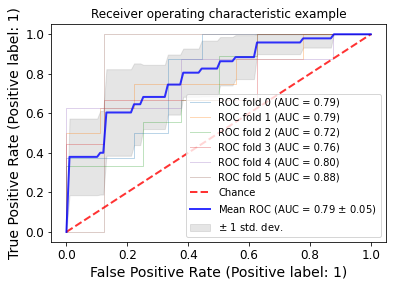

In [20]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
  mean_fpr,
  mean_tpr,
  color="b",
  label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
  lw=2,
  alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
  mean_fpr,
  tprs_lower,
  tprs_upper,
  color="grey",
  alpha=0.2,
  label=r"$\pm$ 1 std. dev.",
)

ax.set(
  xlim=[-0.05, 1.05],
  ylim=[-0.05, 1.05],
  title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()


In [21]:
print(*[x for x in dir(y_train_pred) if not x.startswith('__')])

NameError: name 'y_train_pred' is not defined

We can now get the confusion matrix using the `confusion_matrix()` function. We pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`):

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

### Confusion Matrices

---

Confusion matrices will fit any binary classification problem.

In [ ]:
import pandas as pd

data = {'Predicted Positive (PredP)': ['True Positive (TP)', 'False Positive (FP)'],
        'Predicted Negative (PredN)': ['False Negative (FN)', 'True Negative (TN)']}

df = pd.DataFrame(data, index=['Real Positive (RealP)', 'Real Negative (RealN)'])
df

,Predicted Positive (PredP),Predicted Negative (PredN)
Real Positive (RealP),True Positive (TP),False Negative (FN)
Real Negative (RealN),False Positive (FP),True Negative (TN)


### Rows

---

$$RealP = TP + FN$$
$$RealN = FP + TN$$

#### Recall

---

$$ \text{recall} = \frac{TP}{TP + FN} $$


### Columns

---

$$PredP = TP + FP$$
$$PredN = FN + TN$$

#### Precision

---

$$ \text{precision} = \frac{TP}{TP + FP} $$

Let's use the iris dataset to see how these evaluations work in `sklearn`.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

tgt_preds = (KNeighborsClassifier()
            .fit(iris_train_ftrs, iris_train_tgt)
            .predict(iris_test_ftrs))

print("accuracy:", accuracy_score(iris_test_tgt, tgt_preds))
cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("confusion matrix:", cm, sep="\n")

accuracy: 0.94
confusion matrix:
[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]


Let's make the confusion matrix a pretty table.

Text(48.0, 0.5, 'Actual')

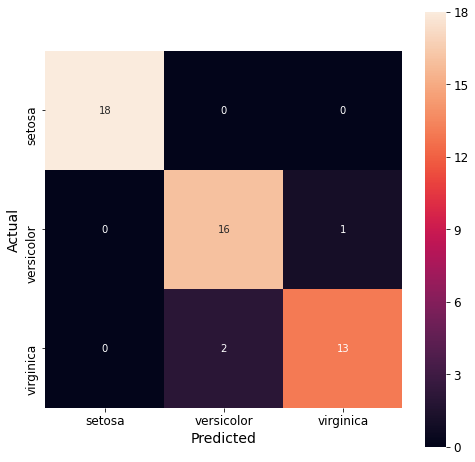

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(iris_test_tgt, tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True,
                 xticklabels=iris.target_names,
                 yticklabels=iris.target_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Dealing with Multiple Classes: Multiclass Averaging

---

How do we compress the rich information in a many-values confusion matrix into simpler values?

In the classification above, we made three mistakes, predicting one Versicolor as Virginica and two Virginica as Versicolor. In our two-class metrics, it was the precision that drew out information about the positive prediction column. When we predict Versicolor, we are correct 16 times and wrong 2. Considering Versicolor by itself, we can calculate something similar to precision giving us $$\frac{16}{18} \approx .89 $$
Similarly, for the Virginica class we get the following. $$\frac{13}{14} \approx .93 $$
Finally, for the Setosa class, we predict $$\frac{18}{18} = 1.0 $$
The mean of $\{\frac{16}{18}, \frac{13}{14}, 1\}$ is about .9392.


In [ ]:
from fractions import Fraction
import numpy as np
Versicolor_acc = 16/18
Virginica_acc = 13/14
Setosa_acc = 1
accuracies = [Versicolor_acc, Virginica_acc, Setosa_acc]
accuracies_arr = np.array(accuracies)
avg = np.average(accuracies_arr)
round(avg, 4)

0.9392

In `sklearn`, this method of summarizing the predictions is called `macro`. We calculate the *macro precision* by computing a value for each column and calculating the average of these values. To compute the value for one column, we take the diagonal entry in the column--where we are correct--and divide it by the sum of all values in the column.

In [ ]:
from sklearn.metrics import precision_score
macro_prec = precision_score(iris_test_tgt,
                             tgt_preds, average='macro')
print("macro:", macro_prec)
cm = metrics.confusion_matrix(iris_test_tgt, tgt_preds)
n_labels = len(iris.target_names)
print("should equal 'macro avg':",
      # correct          column              # columns
      (np.diag(cm) / cm.sum(axis=0)).sum() / n_labels)


macro: 0.9391534391534391
should equal 'macro avg': 0.9391534391534391


The `micro` average "calculates metrics globally" and provides a broader look at the results. `micro` takes all the *correct* predictions and divides by *all* the predictions made. These come from (1) the sum of the values on the diagonal of the confusion matrix and (2) the sum of all values in the confusion matrix.

In [ ]:
from sklearn.metrics import precision_score
print("micro:", precision_score(iris_test_tgt, tgt_preds, average='micro'))

cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("should equal avg='micro':",
      # TP.sum() / (TP&FP).sum() -->
      # all correct / all preds
      np.diag(cm).sum() / cm.sum())

micro: 0.94
should equal avg='micro': 0.94


#### Support

---

The `classification_report` wraps several of these pieces together. It computes the one-versus-all statistics and computes a *weighted* average of the values--like `macro` except with different weights. The weights come from the *support*. In a learning context, the support of a classification rule--*if x is a cat and x is striped, and x is big, then x is a tiger*--is the count of the examples where the rule applies. In other words, if 45 out of 100 examples meet the constraints on the left-hand side of the _if_, the support is 45.

In `classification_report`, it is the "support in reality" of our examples, equivalent to the total counts in each *row* of the confusion matrix.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(iris_test_tgt, tgt_preds))
# average is a weighted macro average (see text)

# verify sums-across-rows
cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("row counts equal support:", cm.sum(axis=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.89      0.94      0.91        17
           2       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

row counts equal support: [18 17 15]


# $F_1$ Score

---

$F_1$ computes a different kind of average from the confusion matrix. By average, we are talking about a measure of center. We already know about the mean and median (the middle-most of sorted values). There are other types of averages out there and the ancient Greeks cared about three averages or means: the arithmetic mean, the geometric mean, and the harmonic mean. 

A helpful view for us is that the special means, the geometric mean and the harmonic mean, are just wrappers around a converted arithmetic mean. Considering the geometric mean, it is computed by taking the arithmetic mean of the logarithms of the values and then exponentiating the value. What we are concerned with here is the harmonic mean. To compute it we (1) take the arithmetic mean of the reciprocals and then (2) take the reciprocal of that. The harmonic mean is very useful when we need to summarize rates like speed or compare different fractions. $F_1$ is a harmonic mean with a slight tweak. It has a constant in front. However, it's just a harmonic mean with a constant in front. The formula is as follows:

$$ F_1 = 2 \times \frac{1}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} $$

If we apply some algebra by taking common denominators and doing an invert-and-multiply and we get the usual textbook formula for $F_1$.

$$ F_1 = 2\frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}

The formula represents an *equal* tradeoff between precision and recall, which simply means we want to be equally right in the value of our predictions and with respect to the real world. 

With the above, we see and confirm several of the values that we calculated by hand.

### 6.3 ROC Curves

---

Classification methods can do more than just slap a label on an example. They can give a probability to each prediction. Imagine a classifier that compes up with scores for ten individuals who might have a disease. The scores range from .05, .15, ..., .95. Based on training, it is determined that .7 is the best break point between folks that have the disease (higher scores) and folks that are healthy (lower scores). By moving the bar to the left, or lowering the numerical break point, we increase the number of hits (sick claims) that the classifier is making. Let's add in the truth as to whether these people are sick and create a confusion matrix.

In [ ]:
import pandas as pd

d = {'Pred Positive': ['.05 .15 .25', '.35 .45'],
     'Pred Negative': ['.55 .65', '.75 .85 .95']}

df = pd.DataFrame(data=d, index=['Real Positive', 'Real Negative'])
df

,Pred Positive,Pred Negative
Real Positive,.05 .15 .25,.55 .65
Real Negative,.35 .45,.75 .85 .95


Imagine in the confusion matrix that we can move the bar between predicted positives and predicted negatives. Predicted positives are to the left and predicted negatives are to the right. Let's look at the confusion matrix again.

In [ ]:
import pandas as pd

d = {'Predicted Positive': ['TP', 'FP'],
     'Predicted Negative': ['FN', 'TN']}

df = pd.DataFrame(data=d, index=['Real Positive', 'Real Negative'])
df

,Predicted Positive,Predicted Negative
Real Positive,TP,FN
Real Negative,FP,TN


By moving the PredictionBar far enough to the right we change predicted negatives to predicted positives. If we slam the PredictionBar all the way to the right, we predict everything as a predicted positive or sick person. As a side effect, there are no predicted negatives. As a result, there are no false negatives -- we predicted everything as a 1. By predicting everything as a positive, we do great on real positives and terrible on real negatives.

Let's imagine a corresponding scenario where the PredictionBar is moved all the way to the left. Now we predict nothing as positive but everything as negative. Regarding the top row, real positives are all predicted negative. On the bottom, all real negatives are predicted negatives. there is no equivalent setup with a *horizontal* bar between real positives and real negatives. Real cats cannot become real dogs. However, our predictions can change, reality can't.

In learning systems, there are often tradeoffs that must be made. Here, the tradeoff is between how many false positives we will tolerate versus how many false negatives we will tolerate. We can control this tradeoff by moving our prediction bar, by setting a threshold. 

We can be hyper-risk-averse, labeling everyone sick so we don't miss catching a sick person (at the expense that we label some healthy people sick), or we can label everyone healthy, and not treat anyone, even the sick. There are two questions to answer:

1. How do we evaluate and select our threshold? How do we pick a specific tradeoff between false positives and false negatives?
2. How do we compare two different classificaiton systems, both of which have a whole range of possible tradeoffs?

Fortuantely, there is a graphical tool that lets us answer these questions, the *ROC curve*. The long-winded name is the *Receiver Operating Characteristic curve*. Originally it was used to quantify radar tracking of bombers headed toward England during World War II. They needed to determine whether a blip on the radar screen was a real threat (a bomber) or not (a ghosted echo of a plane or a bird): to tell true positives from false positives.

ROC curves are normally drawn in terms of *sensitivity* also called *true positive rate, TPR. $ 1 - specificity $ is the *false positive rate* (FPR). These both measure performance *with respect to the breakdown in the real world. They care how we do based on what is out there in reality. We want to have a *high* TPR: 1.0 is perfect. We want a *low* FPR: 0.0 is great. We can game the system and guarantee a high TPR by making the prediction bar so low that we say *everyone* is positive. But that sends the false up to one. If we say no one is sick, we get a great FPR of zero. There are no false claims of sickness, but our TPR is also zero, while we wanted that value to be near 1.0.

### Patterns in the ROC 





### Binary ROC

How do we make ROC work? There's a single call, `roc_curve`, in the `sklearn.metrics` module that does the heavy lifting after a couple of setup steps. First, let's convert the iris problem into a *binary* classification task to simplify the interpretation of the results. The binary question asks, "Is it *Versicolor*?" The answer is yes or no. Also, we need to invoke the classification scoring mechanism of our classifier so we can tell who is on which side of our prediction bar. Instead of outputting a class like *Versicolor*, we need to know a probability, such as a .7 likelihood of *Versicolor*. We do this by using `predict_proba` instead of the typical `predict` method. `predict_proba` returns probabilities for *False* and *True* in two columns. We are interested in the probability from the *True* column for building the ROC curve.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
is_versicolor = iris.target == 1

tts_1c = train_test_split(iris.data, is_versicolor,
                          test_size=.33, random_state=21)

(iris_1c_train_ftrs, iris_1c_test_ftrs,
 iris_1c_train_tgt, iris_1c_test_tgt) = tts_1c

# build, fit, predict (probability scores) for NB model
gnb = naive_bayes.GaussianNB()
prob_true = (gnb.fit(iris_1c_train_ftrs, iris_1c_train_tgt)
             .predict_proba(iris_1c_test_ftrs)[:, 1])  # [:, 1]=="True"

With the setup done, we can do the calculations for the ROC curve and display it.

FPR : [0.     0.     0.     0.0606 0.0606 0.1212 0.1212 0.1818 1.    ]
TPR : [0.     0.0588 0.8824 0.8824 0.9412 0.9412 1.     1.     1.    ]


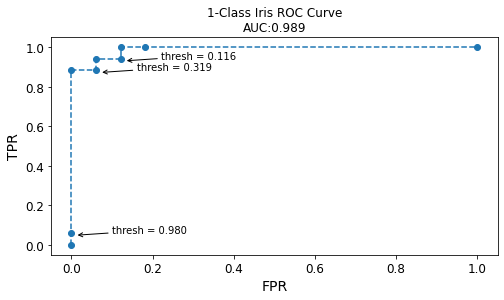

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresh = roc_curve(iris_1c_test_tgt, prob_true)
auc = auc(fpr, tpr)
print(f"FPR : {fpr}")
print(f"TPR : {tpr}")

# create the main graph
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(fpr, tpr, 'o--')
ax.set_title(f"1-Class Iris ROC Curve\nAUC:{auc:.3f}")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

# do a bit of work to label some points with their respective thresholds
investigate = np.array([1, 3, 5])
for idx in investigate:
    th, f, t = thresh[idx], fpr[idx], tpr[idx]
    ax.annotate(f'thresh = {th:.3f}', xy=(f+.01, t-.01),
                xytext=(f+.1, t), arrowprops={'arrowstyle': '->'})


Most of the FPR values are between 0.0 and 0.2, while the TPR values quickly jump into the range of 0.9 to 1.0. Let's take a look at the calculation of those values. Each point represents a different confusion matrix based on its own unique threshold. The following shows the confusion matrices for the second, fourth, and sixth thresholds labeled in the last graph. Due to zero-based ine to the variable xing, these occur at indices 1, 3, 5and 5 which were assigned to the variable `investigate` in the previous cell. We could have picked any of the eight thresholds that `sklearn` found. Let's look at these values.

Text(84.0, 0.5, 'Actual')

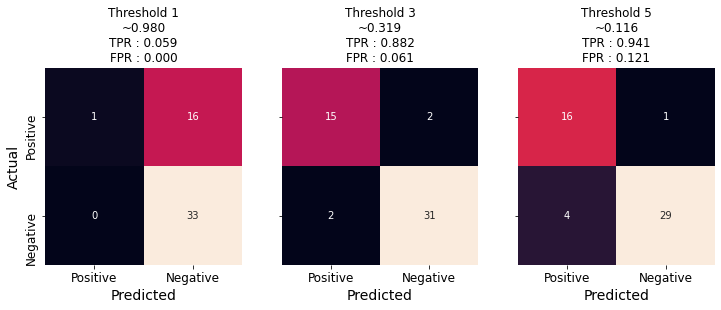

In [25]:
title_fmt = "Threshold {}\n~{:5.3f}\nTPR : {:.3f}\nFPR : {:.3f}"

pn = ['Positive', 'Negative']
add_args = {'xticklabels': pn,
            'yticklabels': pn,
            'square': True}
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for ax, thresh_idx in zip(axes.flat, investigate):
    preds_at_th = prob_true < thresh[thresh_idx]
    cm = sklearn.metrics.confusion_matrix(1-iris_1c_test_tgt, preds_at_th)
    sns.heatmap(cm, annot=True, cbar=False, ax=ax, **add_args)

    ax.set_xlabel('Predicted')
    ax.set_title(title_fmt.format(thresh_idx,
                                  thresh[thresh_idx],
                                  tpr[thresh_idx],
                                  fpr[thresh_idx]))

axes[0].set_ylabel('Actual')



Let's say we want use the confusion matrix to determine how well a classifier identifies sick people.

### AUC: Area-Under-the-(ROC)-Curve

---

How can we summarize an ROC curve as a single value? We answer by calculating the *area under the curve* (AUC) that we've just drawn. The AUC is an *overall* measure of classifier performance at a series of thresholds. The benefit of single-value summaries is that we can easily compute other statistics on them and summarize them graphically. Let's look at several cross-validated AUCs displayed simultaneously on a strip plot.

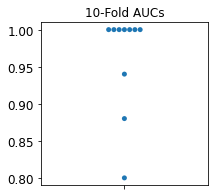

In [26]:
fig,ax = plt.subplots(1, 1, figsize=(3, 3))
model = sklearn.neighbors.KNeighborsClassifier(3)
cv_auc = sklearn.model_selection.cross_val_score(model, iris.data, iris.target==1, scoring='roc_auc', cv=10)
ax = sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold AUCs');

Many folds return perfect results.

`sklearn.metrics.roc_curve` is ill-equipped to deal with multiclass problems. We can work around this by recoding our tri-class problem into a series of me-versus-the-world or one-versus-rest (OvR) alternatives. OvR means we compare each of the following binary problems: 0 versus [1, 2], 1 versus [0, 2];, and 2 versus [0, 2]. The difference here is that we do it for all three possibilities. The basic tool to encode these comparisons into our data is `label_binarize`. Let's look at examples 0, 50, and 100 from the original multiclass data.

## Multiclass Learners, One-versus-Rest, and ROC

---

In [27]:
checkout = [0, 50, 100]
print("Original Encoding")
print(iris.target[checkout])

Original Encoding
[0 1 2]


Therefore, examples 0, 50, and 100 correspond to classes 0, 1, and 2. When we binarize, the classes become:

In [30]:
print("'Multi-label' Encoding")
print(sklearn.preprocessing.label_binarize(y=iris.target,classes=[0, 1, 2])[checkout])

'Multi-label' Encoding
[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [32]:
import pandas as pd

d = {'0': ['1', '0', '0'],
     '1': ['0', '1', '0'],
     '2': ['0', '0', '1']}

df = pd.DataFrame(data=d, index=['0', '1', '2'])
df

,0,1,2
0,1,0,0
1,0,1,0
2,0,0,1


Let's look at another example.

In [31]:
from sklearn.preprocessing import label_binarize
label_binarize(y=[1, 6], classes=[1, 2, 4, 6])

array([[1, 0, 0, 0],
       [0, 0, 0, 1]])

In [33]:
import pandas as pd

d = {'1': ['1', '0'],
     '2': ['0', '0'],
     '4': ['0', '0'],
     '6': ['0', '1']}

df = pd.DataFrame(data=d, index=['1', '6'])
df


,1,2,4,6
1,1,0,0,0
6,0,0,0,1


The class ordering is preserved:

In [34]:
label_binarize([1, 6], classes=[1, 6, 4, 2])

array([[1, 0, 0, 0],
       [0, 1, 0, 0]])

Binary targets transfrom to a column vector:

In [35]:
sklearn.preprocessing.label_binarize(['yes', 'no', 'no', 'yes'], classes=['no', 'yes'])

array([[1],
       [0],
       [0],
       [1]])

These encodings are columns of Boolean flags--yes/no for "Is it class _x_?". The first column answers, "Is it class 0?" and the answers are yes, no, and no. Now, we add a layer of complexity to our classifier. Instead of a *single* classifier, we are going to make one classifier for each target class that was just added, the three new target columns. These become (1) a classifier for class 0 versus the rest, (2) a classifier for class 1 versus the rest, and (3) a classifier for class 2 versus the rest. Then, we can look at the individual performance of the three classifiers.

Text(0, 0.5, 'TPR')

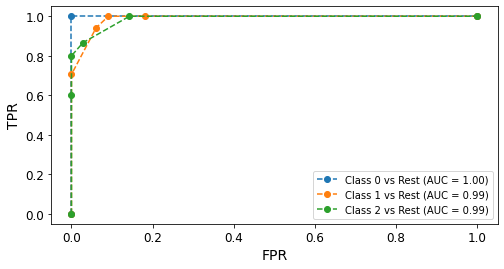

In [43]:
iris_multi_tgt = sklearn.preprocessing.label_binarize(
    y=iris.target, classes=[0, 1, 2])

# im --> "iris multi"

(im_train_ftrs, im_test_ftrs,
 im_train_tgt, im_test_tgt) = sklearn.model_selection.train_test_split(iris.data,
                                                                       iris_multi_tgt, test_size=.33, random_state=21)

# knn wrapped up in one-versus-rest (3 classifiers)
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
ovr_knn = sklearn.multiclass.OneVsRestClassifier(knn)
pred_probs = (ovr_knn.fit(im_train_ftrs, im_train_tgt)
              .predict_proba(im_test_ftrs))

# make ROC plots
fig,ax = plt.subplots(figsize=(8, 4))
for cls in [0, 1, 2]:
    fpr, tpr, _ = sklearn.metrics.roc_curve(im_test_tgt[:,cls],
    pred_probs[:,cls])

    label = f'Class {cls} vs Rest (AUC = {sklearn.metrics.auc(fpr,tpr):.2f})'
    ax.plot(fpr, tpr, 'o--', label=label)

ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")


# Another Take on Multiclass: One-versus-One

There is another take on dealing with the sometimes negative interaction between multiclass problems and learning systems. In one-versus-rest, we chunk off apples against all other fruit in one grand binary problem. For apples, we create *one* one-versus-rest classifier. Another way to do this is to chuch off apple-versus-banana, apple-versus-orange, and so on. Then, instead of one grand Boolean comparison for apples, we make $n - 1$ comparisons, where  $n$ is the number of classes we have. This alternative is called *one-versus-one*. How do we wrap the one-versus-one winners into a grand winner for making a single prediction? We can take the sums of the individual wins and the class with the biggest number of wins in the class we predict. The one-versus-one wrapper gives us *classification scores* for each individual class. The values are *not* probabilities. We take the index of the maximum classification score to find the single best-predicted class.

In [44]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
ovo_knn = sklearn.multiclass.OneVsOneClassifier(knn)
pred_scores = (ovo_knn.fit(iris_train_ftrs, iris_train_tgt)
                      .decision_function(iris_test_ftrs))
df = pd.DataFrame(pred_scores)
df['class'] = df.values.argmax(axis=1)
display(df.head())


,0,1,2,class
0,-0.2222,2.1667,1.1667,1
1,2.0000,1.0000,0.0000,0
2,2.0000,1.0000,0.0000,0
3,2.0000,1.0000,0.0000,0
4,-0.2222,2.1667,1.1667,1


Let's put the actual classes beside the one-versus-one classification scores:

In [47]:
# note: ugly way to make column headers
mi = pd.MultiIndex([['Class Indicator', 'Vote'], [0, 1, 2]],
                   [[0]*3+[1]*3, list(range(3)) * 2])
df = pd.DataFrame(np.c_[im_test_tgt, pred_scores], columns=mi)
display(df.head())


Class Indicator                                            \
                     0                    1                    2   
0               0.0000               1.0000               0.0000   
1               1.0000               0.0000               0.0000   
2               1.0000               0.0000               0.0000   
3               1.0000               0.0000               0.0000   
4               0.0000               1.0000               0.0000   

                  Vote                                            
                     0                    1                    2  
0              -0.2222               2.1667               1.1667  
1               2.0000               1.0000               0.0000  
2               2.0000               1.0000               0.0000  
3               2.0000               1.0000               0.0000  
4              -0.2222               2.1667               1.1667

In [46]:
Parameters_index = '\n'.join(pd.MultiIndex.__doc__.splitlines()).index('Parameters')
print('\n'.join(pd.MultiIndex.__doc__.splitlines())[:])



    A multi-level, or hierarchical, index object for pandas objects.

    Parameters
    ----------
    levels : sequence of arrays
        The unique labels for each level.
    codes : sequence of arrays
        Integers for each level designating which label at each location.
    sortorder : optional int
        Level of sortedness (must be lexicographically sorted by that
        level).
    names : optional sequence of objects
        Names for each of the index levels. (name is accepted for compat).
    copy : bool, default False
        Copy the meta-data.
    verify_integrity : bool, default True
        Check that the levels/codes are consistent and valid.

    Attributes
    ----------
    names
    levels
    codes
    nlevels
    levshape

    Methods
    -------
    from_arrays
    from_tuples
    from_product
    from_frame
    set_levels
    set_codes
    to_frame
    to_flat_index
    sortlevel
    droplevel
    swaplevel
    reorder_levels
    remove_unused_levels
    

### DataFrames

There are multiple ways to construct a DataFrame. For instance we can use a dictionary.

In [ ]:
import pandas as pd

d = {'Age': ['25', '26'],
     'Name': ['Scott', 'Linda']}

df = pd.DataFrame(data=d)
df



,Age,Name
0,25,Scott
1,26,Linda


In [ ]:
import pandas as pd

d = {'Name': ['Scott', 'Linda'],
     'Age': ['25', '26']}

df = pd.DataFrame(data=d, index=['Subject1', 'Subject2'])
df.index.name = 'Person'
df


,Name,Age
Person,,
Subject1,Scott,25
Subject2,Linda,26


In [ ]:
import pandas as pd

data = {'Medical Claim': ['Easy to call sick', 'Hard to call sick'],
        'Prediction': ['Easy to predict True', 'Hard to predict False']}

df = pd.DataFrame(data=data, index=['Low', 'High'])
df.index.name = 'Bar'
df

,Medical Claim,Prediction
Bar,,
Low,Easy to call sick,Easy to predict True
High,Hard to call sick,Hard to predict False


In [ ]:
Examples_index = '\n'.join(pd.DataFrame.__doc__.splitlines()).index('Examples')
print('\n'.join(pd.DataFrame.__doc__.splitlines())[Examples_index:])


Examples
    --------
    Constructing DataFrame from a dictionary.

    >>> d = {'col1': [1, 2], 'col2': [3, 4]}
    >>> df = pd.DataFrame(data=d)
    >>> df
       col1  col2
    0     1     3
    1     2     4

    Notice that the inferred dtype is int64.

    >>> df.dtypes
    col1    int64
    col2    int64
    dtype: object

    To enforce a single dtype:

    >>> df = pd.DataFrame(data=d, dtype=np.int8)
    >>> df.dtypes
    col1    int8
    col2    int8
    dtype: object

    Constructing DataFrame from numpy ndarray:

    >>> df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
    ...                    columns=['a', 'b', 'c'])
    >>> df2
       a  b  c
    0  1  2  3
    1  4  5  6
    2  7  8  9

    Constructing DataFrame from a numpy ndarray that has labeled columns:

    >>> data = np.array([(1, 2, 3), (4, 5, 6), (7, 8, 9)],
    ...                 dtype=[("a", "i4"), ("b", "i4"), ("c", "i4")])
    >>> df3 = pd.DataFrame(data, columns=['c', 'a'])
    ...
    

 

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In the above matrix, the number in the first row and first column indicates that the classifier correctly identified 53,124 images as non-5s. These are also known as *true negatives*. The remaining 1,455 images in the first row and second column are known as *false positives* and represent images the classifier incorrectly categorized as 5s, which indeed were not.

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. 
In the above matrix, the number in the first row and first column indicates that the classifier correctly identified 53,124 images as non-5s. These are also known as *true negatives*. The remaining 1,455 images in the first row and second column are known as *false positives* and represent images the classifier incorrectly categorized as 5s, which indeed were not. 

Next, in the second row, the number in the first column (949) indicates the images that the classifier incorrectly identified as non-5s. In other words, the images were fives, but the classifier said they were not. These are known as *false negatives*. Finally, the remaining 4,472 images in the bottom right corner are *true positives*, the fives that the classifier identified correctly. A perfect classifier would have only true positives and true negatives.

Using a confusion matrix, we can compute additional metrics, one of which is the *precision* or the accuracy of the positive predictions. Let's take a look at a few more simple examples.

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

In [ ]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

In the case of a binary classifier, we can extract the true positives, false positives, true negatives, and false negatives.

In [ ]:
from sklearn import metrics
import textwrap
print(textwrap.fill(str(sorted(metrics.SCORERS.keys())), width=70))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score',
'average_precision', 'balanced_accuracy', 'completeness_score',
'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples',
'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score',
'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples',
'jaccard_weighted', 'matthews_corrcoef', 'max_error',
'mutual_info_score', 'neg_brier_score', 'neg_log_loss',
'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error',
'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance',
'neg_mean_squared_error', 'neg_mean_squared_log_error',
'neg_median_absolute_error', 'neg_root_mean_squared_error',
'normalized_mutual_info_score', 'precision', 'precision_macro',
'precision_micro', 'precision_samples', 'precision_weighted', 'r2',
'rand_score', 'recall', 'recall_macro', 'recall_micro',
'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo',
'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted',
'top_k_accuracy', 

Not all these metrics are designed for classifiers. How can we identify the scorer used for a particular classifier, say, *k*-NN? You can see the whole output with `help(knn.score).` However, let's trim it down a bit.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

knn = KNeighborsClassifier()

#help(knn.score) # verbose, but complete

#print(knn.score.__doc__.splitlines()[0])
#print('\n--and--\n')
examples_index = "\n".join(np.ravel.__doc__.splitlines()).index('Examples')
print("\n".join(np.ravel.__doc__.splitlines())[examples_index:])
search_word_index = '\n'.join(np.ravel.__doc__.splitlines()).index('search_word')
print('\n'.join(np.ravel.__doc__.splitlines())[search_word_index:])

Examples
    --------
    It is equivalent to ``reshape(-1, order=order)``.

    >>> x = np.array([[1, 2, 3], [4, 5, 6]])
    >>> np.ravel(x)
    array([1, 2, 3, 4, 5, 6])

    >>> x.reshape(-1)
    array([1, 2, 3, 4, 5, 6])

    >>> np.ravel(x, order='F')
    array([1, 4, 2, 5, 3, 6])

    When ``order`` is 'A', it will preserve the array's 'C' or 'F' ordering:

    >>> np.ravel(x.T)
    array([1, 4, 2, 5, 3, 6])
    >>> np.ravel(x.T, order='A')
    array([1, 2, 3, 4, 5, 6])

    When ``order`` is 'K', it will preserve orderings that are neither 'C'
    nor 'F', but won't reverse axes:

    >>> a = np.arange(3)[::-1]; a
    array([2, 1, 0])
    >>> a.ravel(order='C')
    array([2, 1, 0])
    >>> a.ravel(order='K')
    array([2, 1, 0])

    >>> a = np.arange(12).reshape(2,3,2).swapaxes(1,2); a
    array([[[ 0,  2,  4],
            [ 1,  3,  5]],
           [[ 6,  8, 10],
            [ 7,  9, 11]]])
    >>> a.ravel(order='C')
    array([ 0,  2,  4,  1,  3,  5,  6,  8, 10,  7,  9, 11])
 

In [ ]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
(tn, fp, fn, tp)

(0, 2, 1, 1)

Using the 5 and non-5 classifier, we get the following results.

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_train_5, y_train_pred).ravel()
(tn, fp, fn, tp)

(53124, 1455, 949, 4472)

## `ravel()`

---

Let's look at the confusion matrix one more time.

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

We can use the $\text{TN}$, $\text{FP}$, $\text{FN}$, and $\text{TP}$ to calculate additional metrics. For instance, **precison** represents the accuracy of the positive predictions and is calculated via the following equation:

$$ \text{precision} = \frac{TP}{TP + FP} $$


Let's calculate the precision.

In [ ]:
precision = tp / (tp + fp)
print(f'Precision: {precision:.2f}')

Precision: 0.75


`numpy.ravel()` 


## Precision

---


## Recall

---

$recall = \frac{TP}{TP + FN}$ 
